# Netflix Global Strategy — Figures Notebook

Figures created:
1. **Top 10 countries by number of titles** (horizontal bar chart)
2. **US vs Non-US titles over time** (stacked area chart, by `release_year`)
3. **Top 5 regions: Movies vs TV Shows** (grouped bar chart with % labels)

In [9]:
# Imported library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [10]:
# Load data

csv_path = Path(r"C:\Users\sze ming chak\Documents\003_Netflix project\netflix_titles.csv")

df = pd.read_csv(csv_path)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [11]:
# sanity check

print("Rows, columns:", df.shape)
print("\nColumns:", list(df.columns))
print("\nMissing values in 'country':", df['country'].isna().sum() if 'country' in df.columns else "No 'country' column found")

Rows, columns: (8807, 12)

Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']

Missing values in 'country': 831


# Data curation
We extract a **primary_country** as the first listed country in the `country` field.

- Example: `"United States, India"` → `"United States"`
- Missing `country` → excluded from country-level counts


In [12]:
# Create primary_country from the first country listed
df['primary_country'] = (
    df['country']
      .astype('string')                 # keeps <NA> properly
      .str.split(',')                   # split into list
      .str[0]                           # take first element
      .str.strip()                      # trim whitespace
)

# Keep only rows where primary_country exists for country-level analysis
df_geo = df.dropna(subset=['primary_country']).copy()

print("Rows kept for country analysis:", len(df_geo))
df_geo[['title', 'type', 'country', 'primary_country']].head(10)

# year
YEAR_MIN, YEAR_MAX = 2010, 2021
df_geo = df_geo[(df_geo["release_year"] >= YEAR_MIN) & (df_geo["release_year"] <= YEAR_MAX)].copy()

df_geo[["type", "title", "primary_country", "release_year"]].head()


Rows kept for country analysis: 7976


,type,title,primary_country,release_year
0,Movie,Dick Johnson Is Dead,United States,2020
1,TV Show,Blood & Water,South Africa,2021
4,TV Show,Kota Factory,India,2021
8,TV Show,The Great British Baking Show,United Kingdom,2021
9,Movie,The Starling,United States,2021


# Figure1: Top 10 countries by number of titles

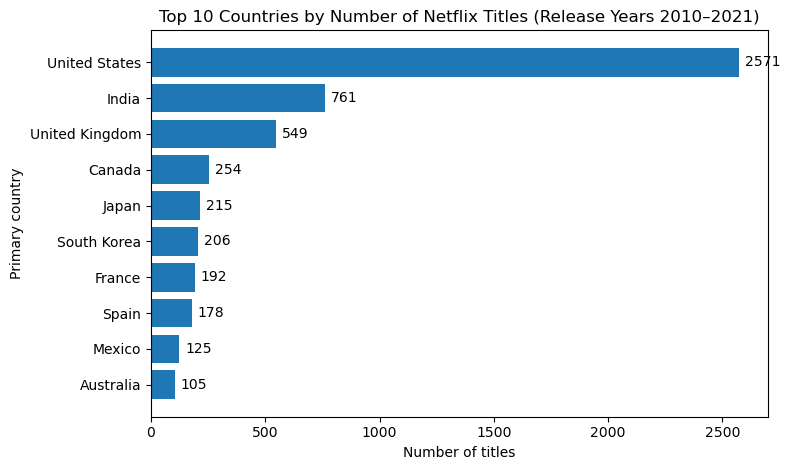

Saved: figures\fig1_top10_countries.png


In [13]:
top10 = df_geo["primary_country"].value_counts().head(10).sort_values()

plt.figure(figsize=(8, 4.8))
plt.barh(top10.index, top10.values)
plt.title("Top 10 Countries by Number of Netflix Titles (Release Years {}–{})".format(YEAR_MIN, YEAR_MAX))
plt.xlabel("Number of titles")
plt.ylabel("Primary country")

# Add value labels
for i, v in enumerate(top10.values):
    plt.text(v + max(top10.values)*0.01, i, str(v), va="center")

plt.tight_layout()

# Save for your report
out_dir = Path("figures")
out_dir.mkdir(exist_ok=True)
fig_path1 = out_dir / "fig1_top10_countries.png"
plt.savefig(fig_path1, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", fig_path1)

# Calculate Top 3 Concentration Ratio

In [14]:
# Count number of titles per country
country_counts = df['primary_country'].value_counts()

# Total number of titles (after cleaning)
total_titles = len(df)

# Get top 3 countries
top3 = country_counts.head(3)

# Calculate concentration ratio (CR3)
cr3 = top3.sum() / total_titles * 100

print("Top 3 countries:")
print(top3)
print(f"\nTop 3 concentration ratio (CR3): {cr3:.2f}%")


Top 3 countries:
primary_country
United States     3211
India             1008
United Kingdom     628
Name: count, dtype: int64

Top 3 concentration ratio (CR3): 55.04%


# Figure 2: US vs Non-US titles over time (stacked area)

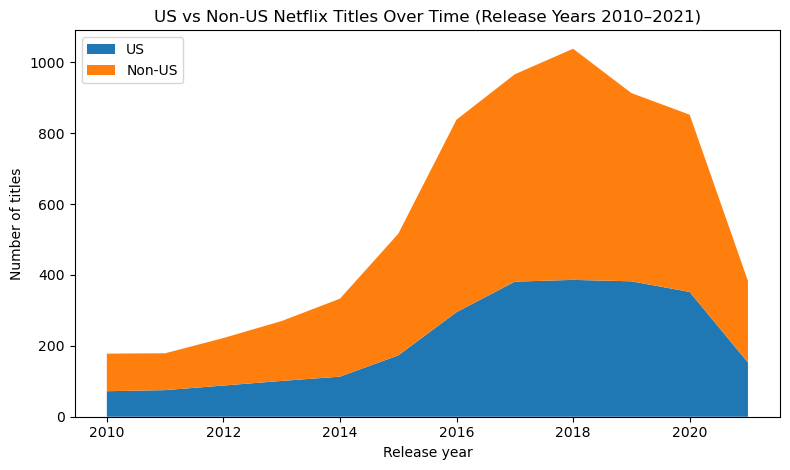

Saved: figures\fig2_us_vs_nonus_stacked_area.png


In [13]:
df_geo["is_us"] = df_geo["primary_country"].eq("United States")

year_counts = (
    df_geo
    .groupby(["release_year", "is_us"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={True: "US", False: "Non-US"})
    .sort_index()
)

years = year_counts.index.to_numpy()
us = year_counts["US"].to_numpy()
nonus = year_counts["Non-US"].to_numpy()

plt.figure(figsize=(8, 4.8))
plt.stackplot(years, us, nonus, labels=["US", "Non-US"])
plt.title("US vs Non-US Netflix Titles Over Time (Release Years {}–{})".format(YEAR_MIN, YEAR_MAX))
plt.xlabel("Release year")
plt.ylabel("Number of titles")
plt.legend(loc="upper left")
plt.tight_layout()

fig_path2 = out_dir / "fig2_us_vs_nonus_stacked_area.png"
plt.savefig(fig_path2, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", fig_path2)

# Region mapping

In [14]:
EUROPE = {
    "United Kingdom","France","Germany","Spain","Italy","Ireland","Belgium","Netherlands","Sweden","Norway",
    "Denmark","Finland","Poland","Switzerland","Austria","Portugal","Greece","Czech Republic","Hungary",
    "Romania","Bulgaria","Ukraine","Russia","Iceland","Luxembourg","Serbia","Croatia","Slovenia","Slovakia",
    "Turkey"  # often grouped with Europe in broad business summaries
}
EAST_ASIA = {"South Korea","Japan","China","Hong Kong","Taiwan","Mongolia"}
SOUTH_ASIA = {"India","Pakistan","Bangladesh","Sri Lanka","Nepal"}
LATAM = {"Mexico","Brazil","Argentina","Colombia","Chile","Peru","Venezuela","Uruguay","Ecuador","Bolivia","Paraguay","Guatemala","Cuba","Dominican Republic"}
MENA = {"Egypt","Saudi Arabia","United Arab Emirates","Jordan","Lebanon","Kuwait","Qatar","Morocco","Tunisia","Algeria","Israel","Iran","Iraq"}
AFRICA = {"South Africa","Nigeria","Kenya","Ghana","Ethiopia","Uganda","Zimbabwe"}
OCEANIA = {"Australia","New Zealand"}

def country_to_region(c: str) -> str:
    if pd.isna(c):
        return np.nan
    if c == "United States":
        return "United States"
    if c in EUROPE:
        return "Europe"
    if c in EAST_ASIA:
        return "East Asia"
    if c in SOUTH_ASIA:
        return "South Asia"
    if c in LATAM:
        return "Latin America"
    if c in MENA:
        return "Middle East & North Africa"
    if c in AFRICA:
        return "Africa"
    if c in OCEANIA:
        return "Oceania"
    if c == "Canada":
        return "Canada"
    return "Other"

df_geo["region"] = df_geo["primary_country"].apply(country_to_region)
df_geo[["primary_country","region"]].head(10)

,primary_country,region
0,United States,United States
1,South Africa,Africa
4,India,South Asia
8,United Kingdom,Europe
9,United States,United States
12,Germany,Europe
15,United States,United States
17,Mexico,Latin America
21,Turkey,Europe
25,Australia,Oceania


# Figure 3: Top 5 regions + Movies vs TV Shows with % labels

Top 5 regions: ['United States', 'Europe', 'South Asia', 'East Asia', 'Latin America']


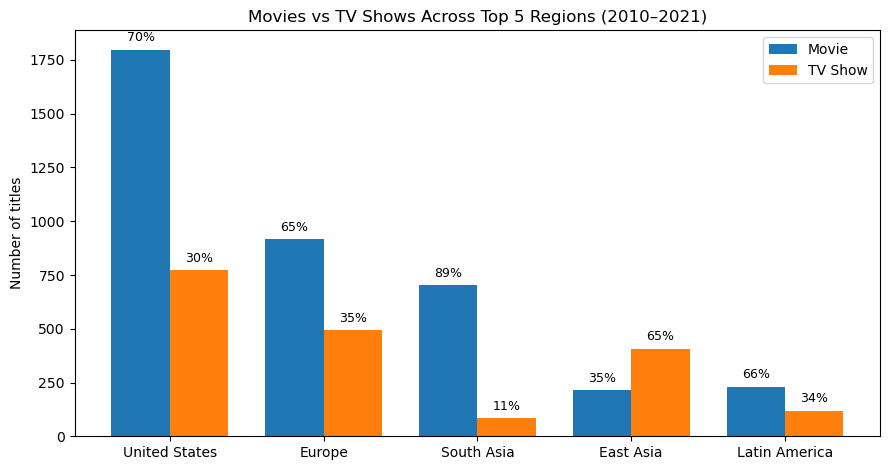

Saved: figures\fig3_top5regions_movie_vs_tv.png


type,Movie,TV Show,Total
region,,,
United States,1798,773,2571
Europe,917,494,1411
South Asia,702,84,786
East Asia,215,407,622
Latin America,231,118,349


In [15]:
# Identify top 5 regions by total titles
region_totals = df_geo["region"].value_counts().dropna()
top5_regions = region_totals.head(5).index.tolist()
print("Top 5 regions:", top5_regions)

df_top5 = df_geo[df_geo["region"].isin(top5_regions)].copy()

# Count titles by region and type
region_type_counts = (
    df_top5
    .groupby(["region", "type"])
    .size()
    .unstack(fill_value=0)
)

# Ensure both columns exist
for col in ["Movie", "TV Show"]:
    if col not in region_type_counts.columns:
        region_type_counts[col] = 0

# Order rows as top5 order
region_type_counts = region_type_counts.loc[top5_regions, ["Movie","TV Show"]]

# Compute within-region percentages for labels
row_sums = region_type_counts.sum(axis=1)
pct = region_type_counts.div(row_sums, axis=0) * 100

# Plot grouped bars
x = np.arange(len(region_type_counts.index))
width = 0.38

plt.figure(figsize=(9, 4.8))
bars1 = plt.bar(x - width/2, region_type_counts["Movie"], width, label="Movie")
bars2 = plt.bar(x + width/2, region_type_counts["TV Show"], width, label="TV Show")

plt.xticks(x, region_type_counts.index, rotation=0)
plt.title("Movies vs TV Shows Across Top 5 Regions ({}–{})".format(YEAR_MIN, YEAR_MAX))
plt.ylabel("Number of titles")
plt.legend(loc="upper right")

# Add % labels above bars
def add_pct_labels(bars, pct_series):
    for bar, p in zip(bars, pct_series):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + max(row_sums)*0.01,
            f"{p:.0f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

add_pct_labels(bars1, pct["Movie"].to_list())
add_pct_labels(bars2, pct["TV Show"].to_list())

plt.tight_layout()
fig_path3 = out_dir / "fig3_top5regions_movie_vs_tv.png"
plt.savefig(fig_path3, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", fig_path3)

# (Optional) Print the table used for plotting
region_type_counts.assign(Total=row_sums).sort_values("Total", ascending=False)
